In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../Datasets/airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.isna().sum()

Passengers    0
dtype: int64

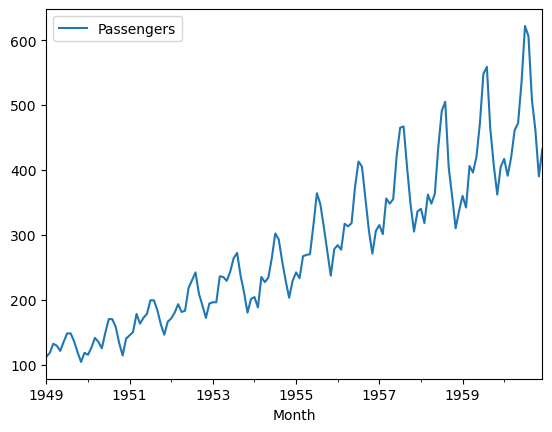

In [5]:
df.plot();

In [6]:
alpha = 0.2

In [7]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [8]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

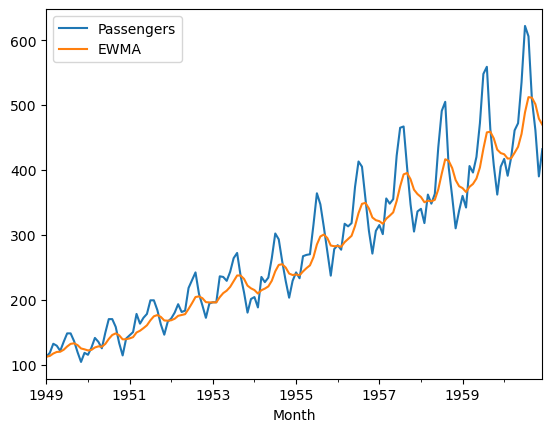

In [9]:
df.plot();

In [10]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

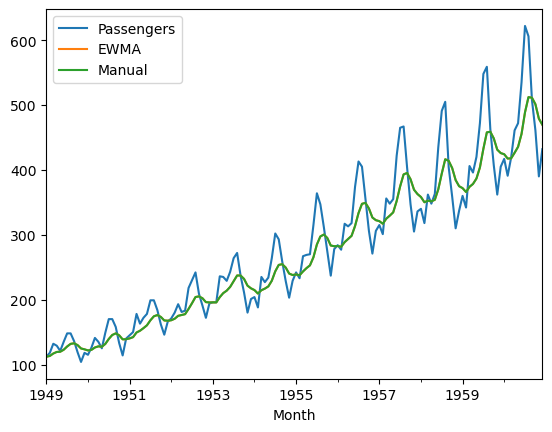

In [11]:
df.plot();

In [12]:
df.drop('Manual', axis=1, inplace=True)

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [14]:
ses = SimpleExpSmoothing(df['Passengers'])

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
df.index.freq = 'MS'

In [16]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [17]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [18]:
res

In [19]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [20]:
np.allclose(df['SES'], res.fittedvalues)

True

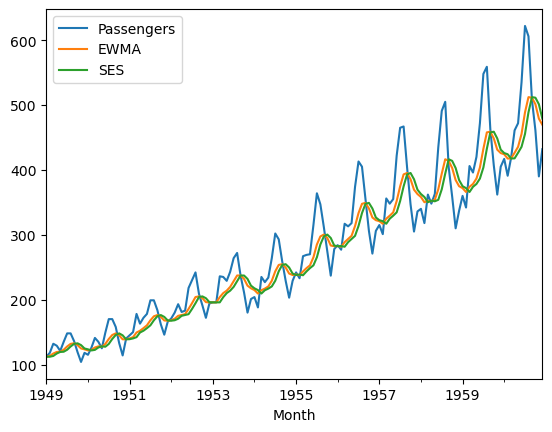

In [21]:
df.plot();

In [22]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [23]:
df['SES-1'] = df['SES'].shift(-1)

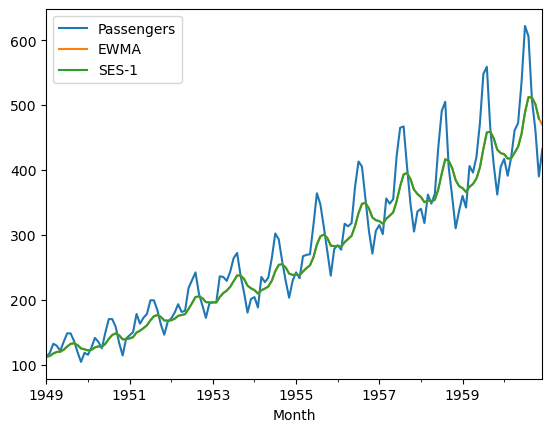

In [24]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [25]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [26]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [27]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

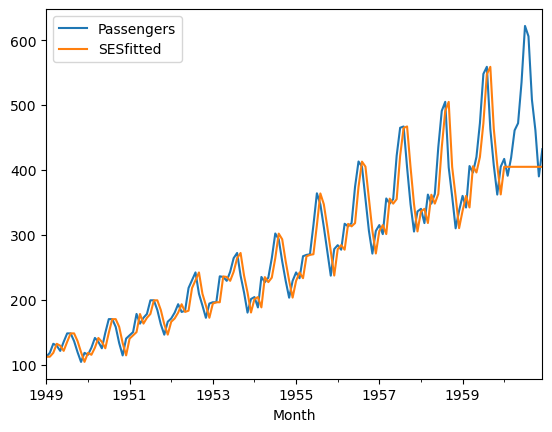

In [28]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [29]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [30]:
from statsmodels.tsa.holtwinters import Holt

In [31]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [32]:
res_h = holt.fit()

In [33]:
df['Holt'] = res_h.fittedvalues

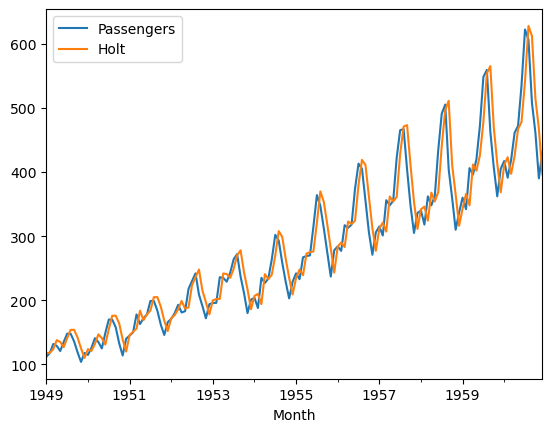

In [34]:
df[['Passengers', 'Holt']].plot();

Train RMSE: 11.852993787434388
Test RMSE: 15.542949752462402
Train MAE: 8.892112773042472
Test MAE: 10.437502293568826
Train RMSE: 10.153934838980348
Test RMSE: 16.535213938259503
Train MAE: 7.55205253266076
Test MAE: 10.683342099494004
Train RMSE: 9.887178133880766
Test RMSE: 19.102109810723295
Train MAE: 7.408706075752775
Test MAE: 13.450533693042743


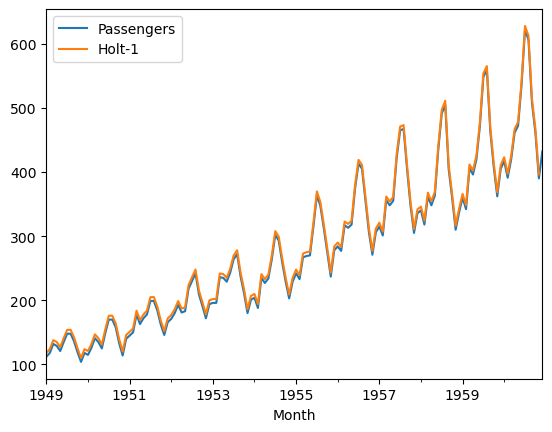

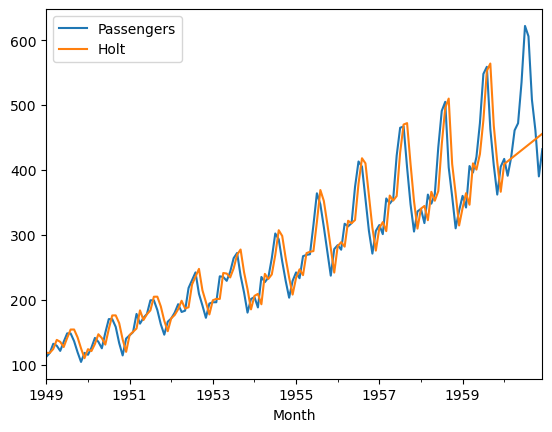

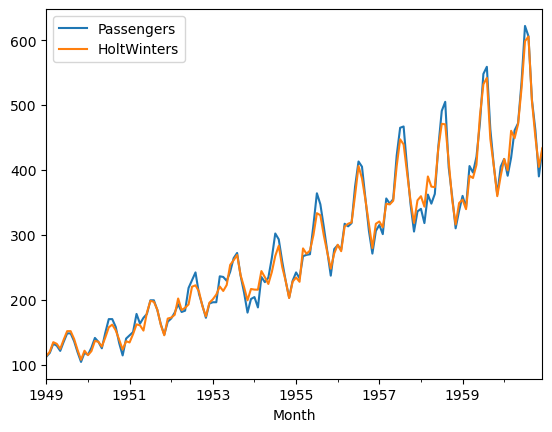

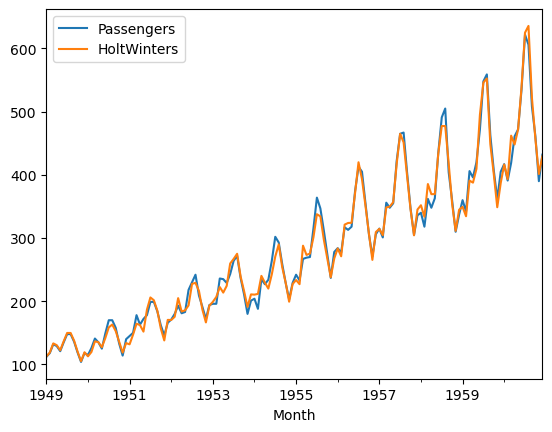

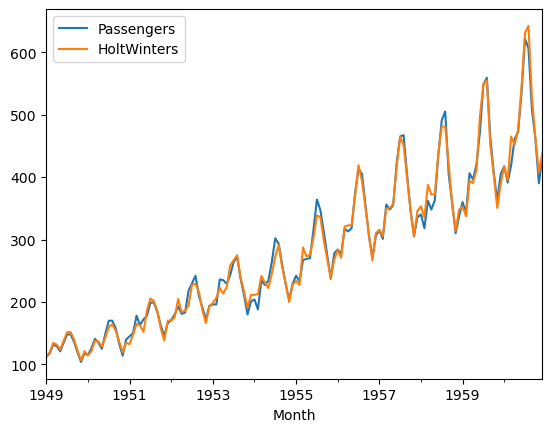

In [35]:
### No!
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()

df.loc[train_idx, 'Holt'] = res_h.fittedvalues
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

df[['Passengers', 'Holt']].plot();

from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))
def mae(y, t):
  return np.mean(np.abs(y - t))
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))